# **House Price - Advanced Regression**

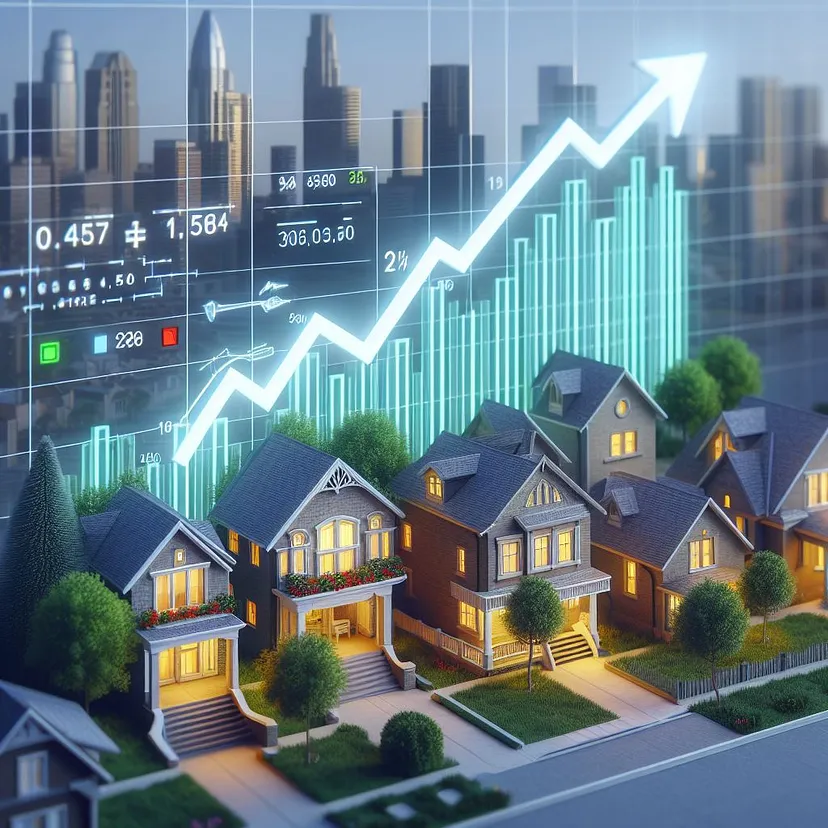

In [28]:
!pip install catboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
%matplotlib inline
from xgboost import XGBRegressor
from catboost import CatBoostRegressor # CatBoostRegressor will now be found
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
pd.pandas.set_option('display.max_columns',None)

# **Load the provided train and test datasets**

In [51]:
# load data

# train data

df=pd.read_csv('/content/train.csv')
df.head()

# test data

df_test=pd.read_csv('/content/test.csv')
df_test.head()

df.shape, df_test.shape


((1460, 81), (1459, 80))

#**Exploratory Data Analysis**

Skewness: 1.882876
Kurtosis: 6.536282


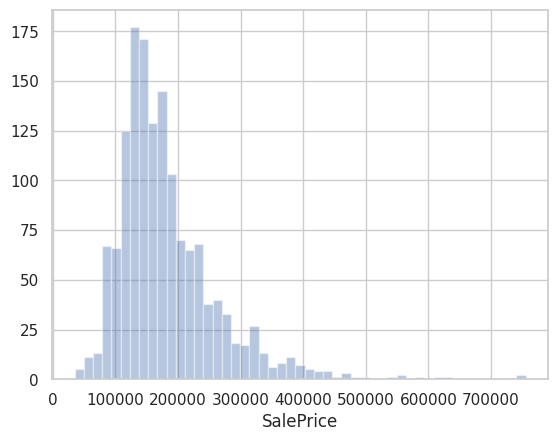

In [30]:
# distribution of values in target feature
sns.distplot(df_train.get("SalePrice"), kde=False)
# skewness and kurtosis
print("Skewness: %f" % df_train.get("SalePrice").skew())
print("Kurtosis: %f" % df_train.get("SalePrice").kurt())

**Observation: The dependent feature 'SalePrice' is right-skewed.**

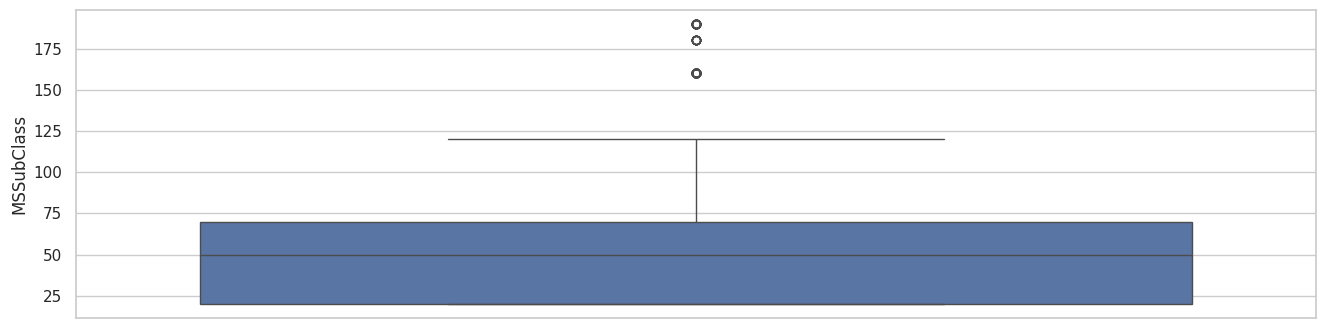

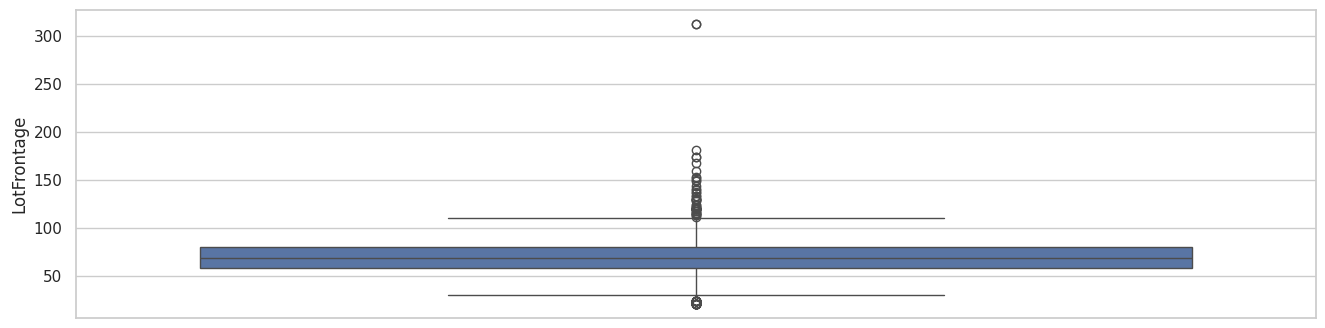

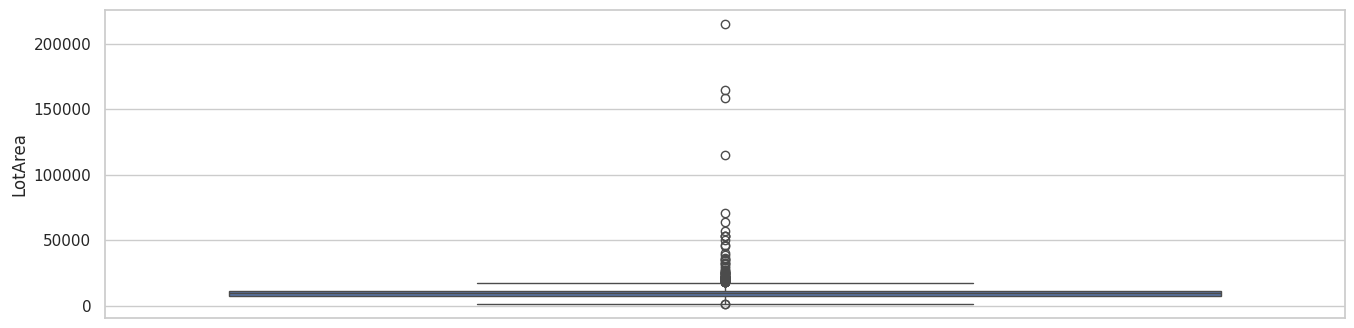

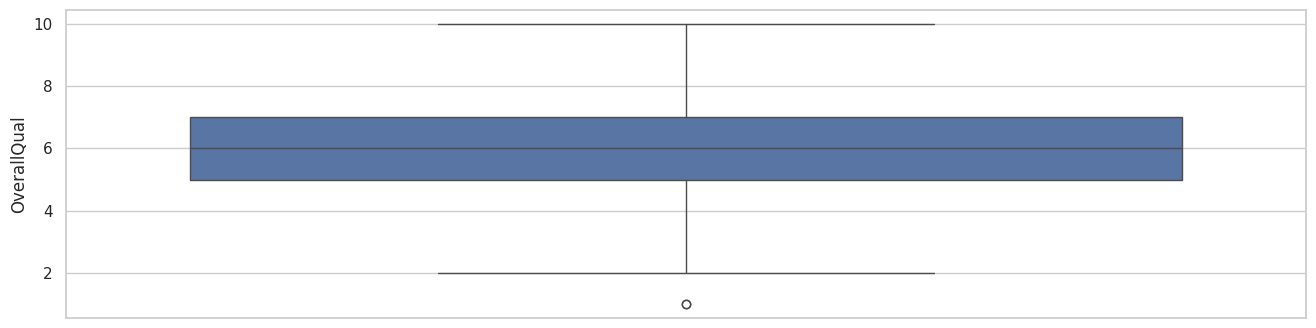

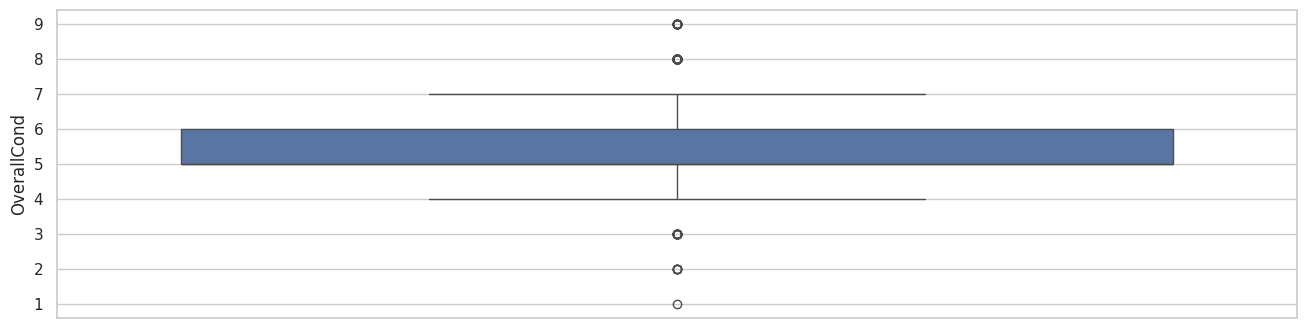

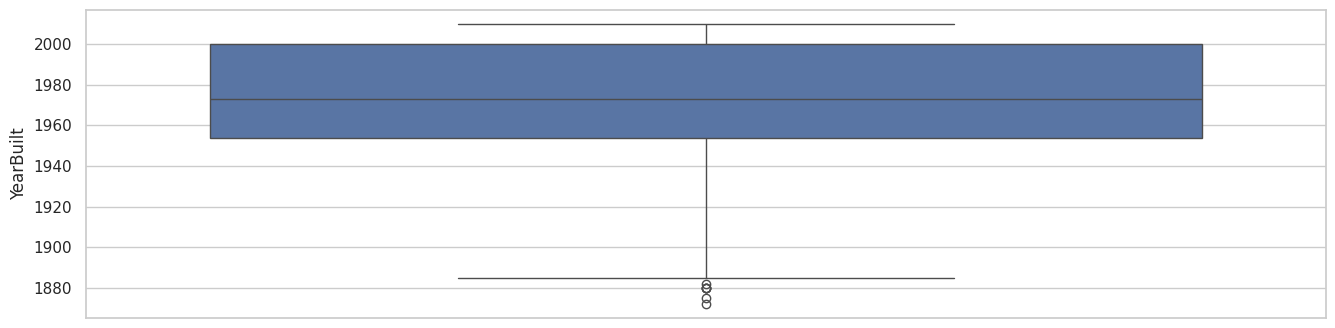

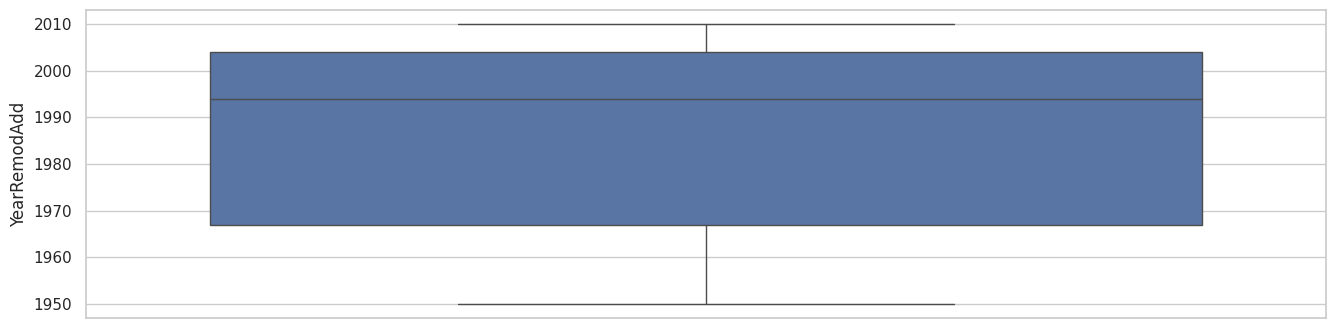

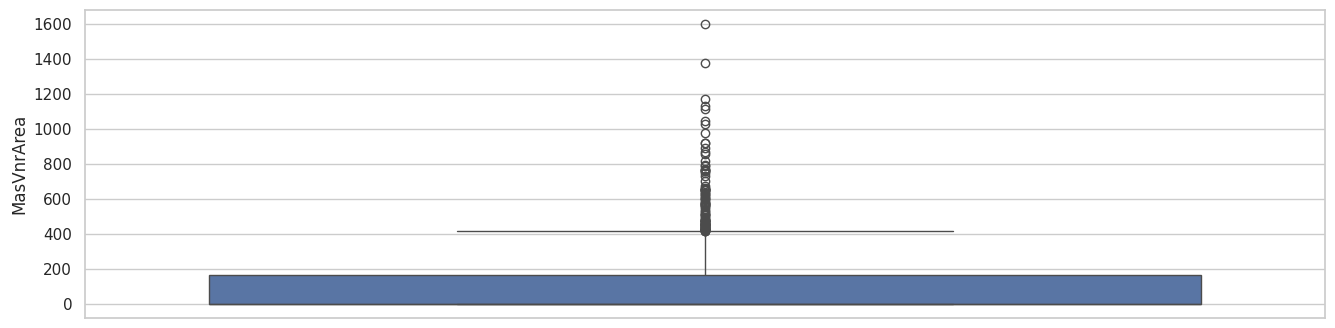

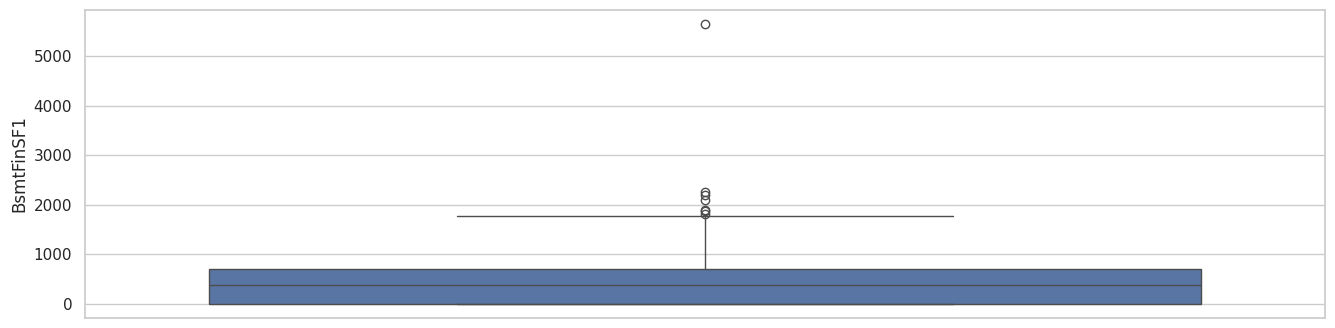

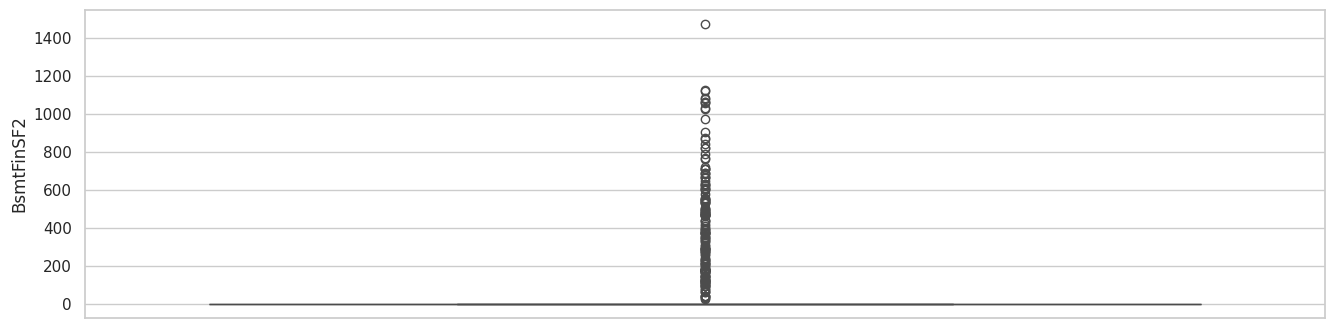

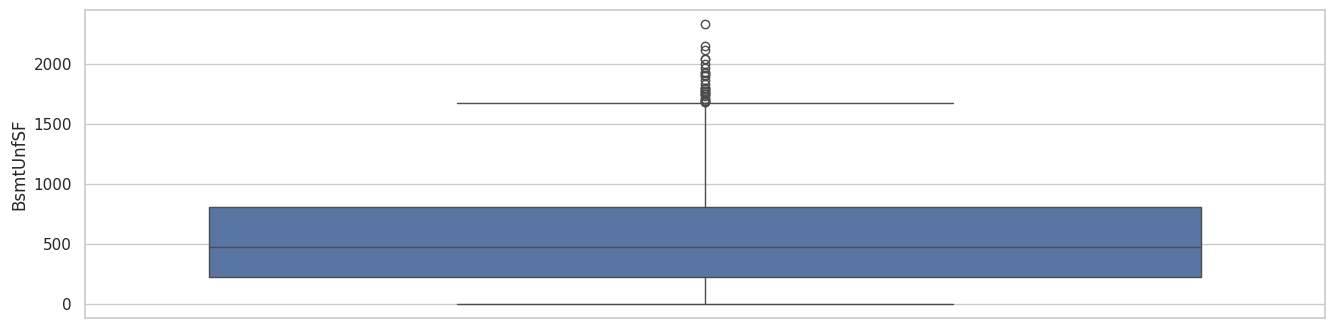

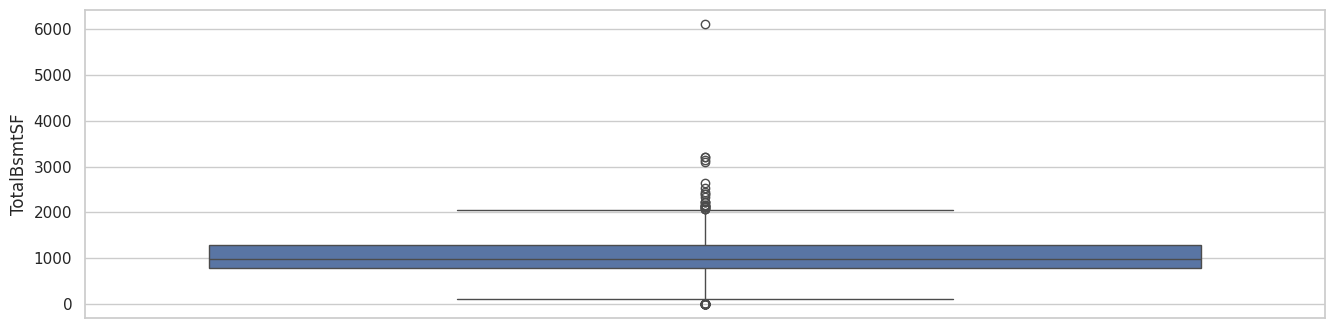

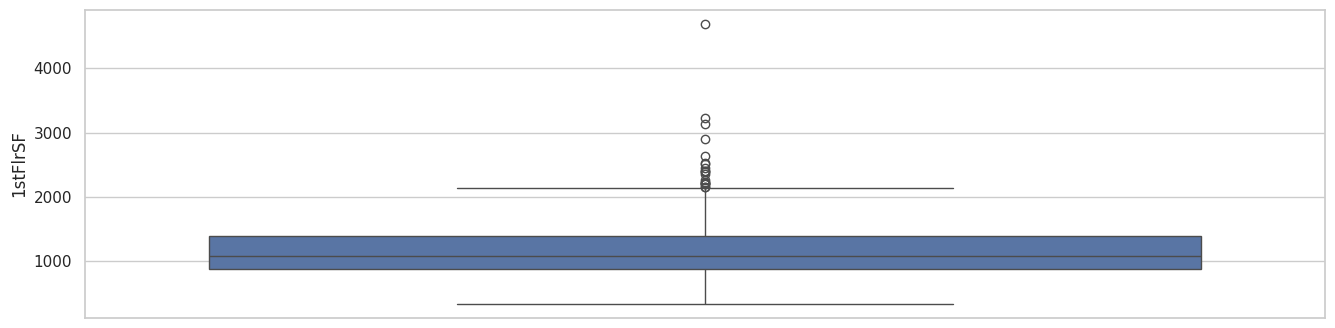

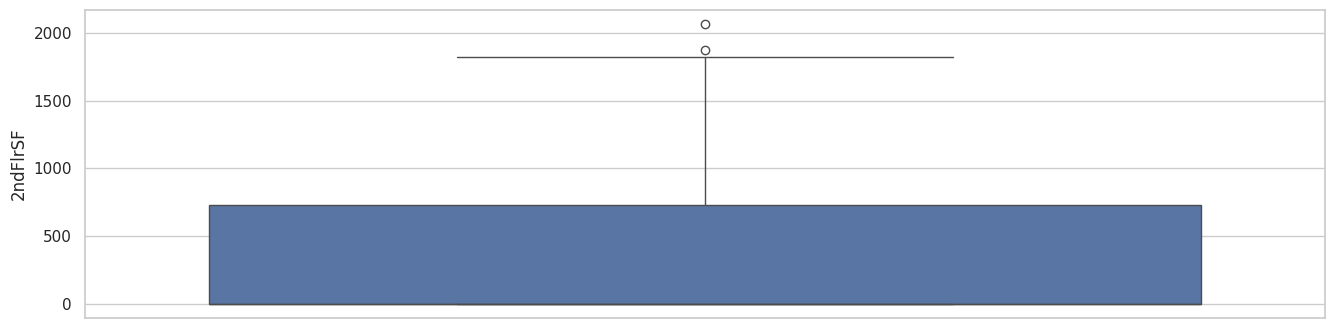

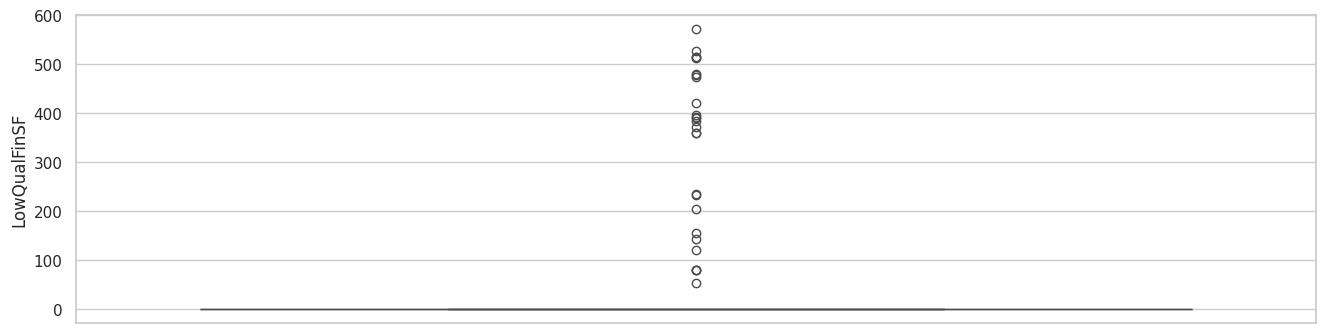

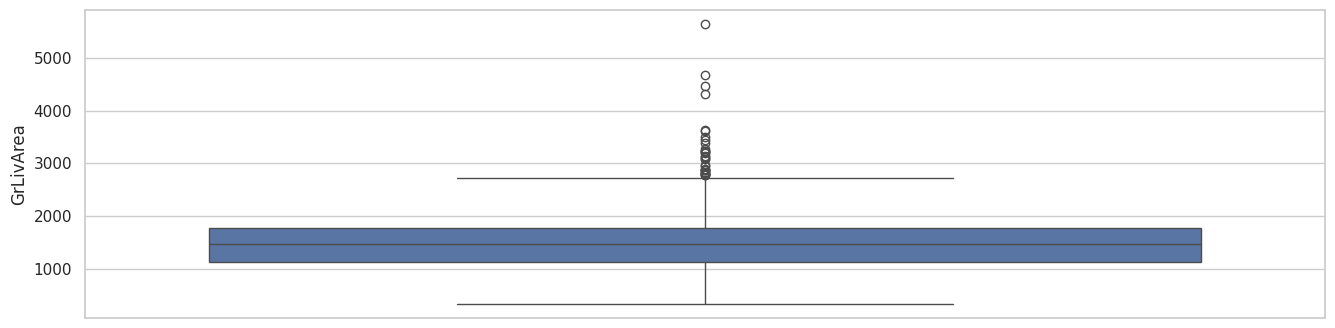

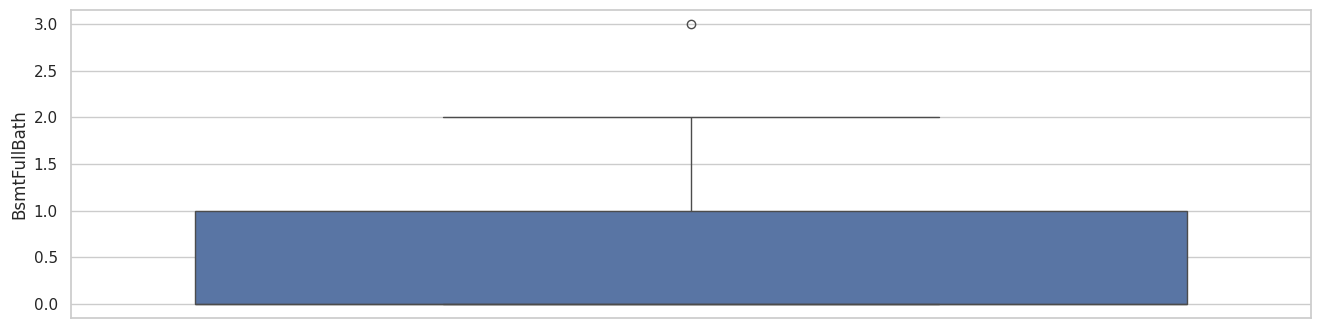

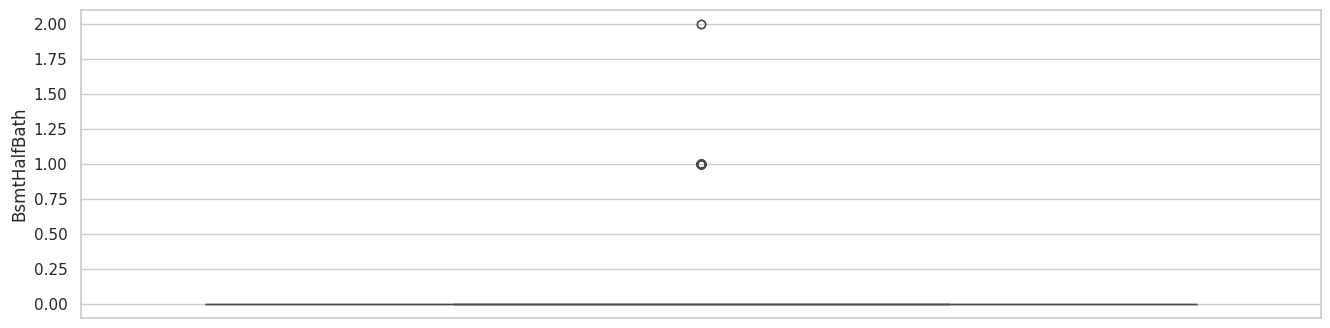

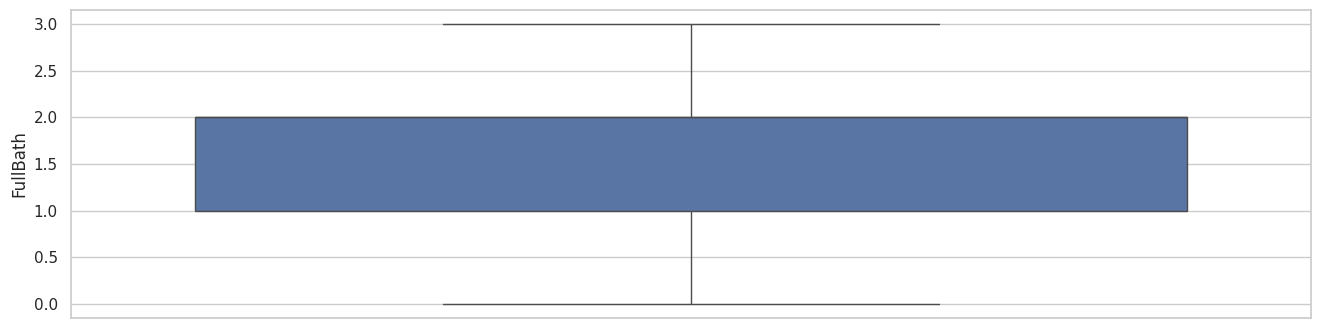

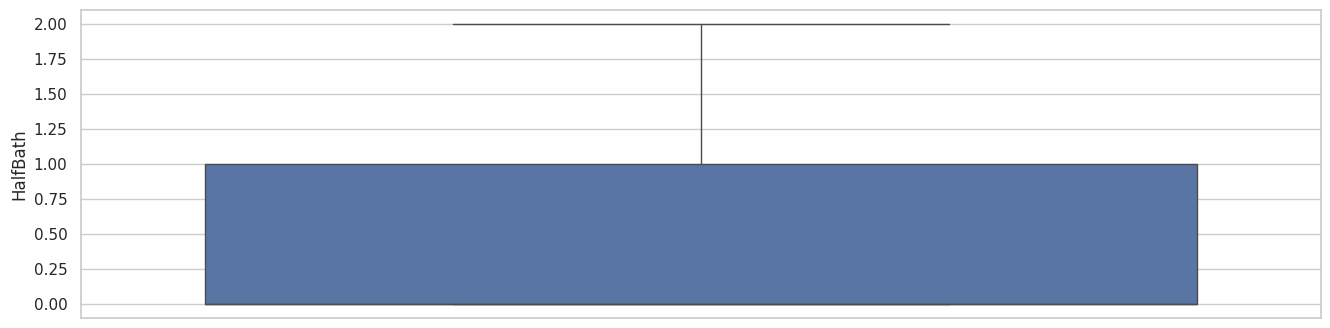

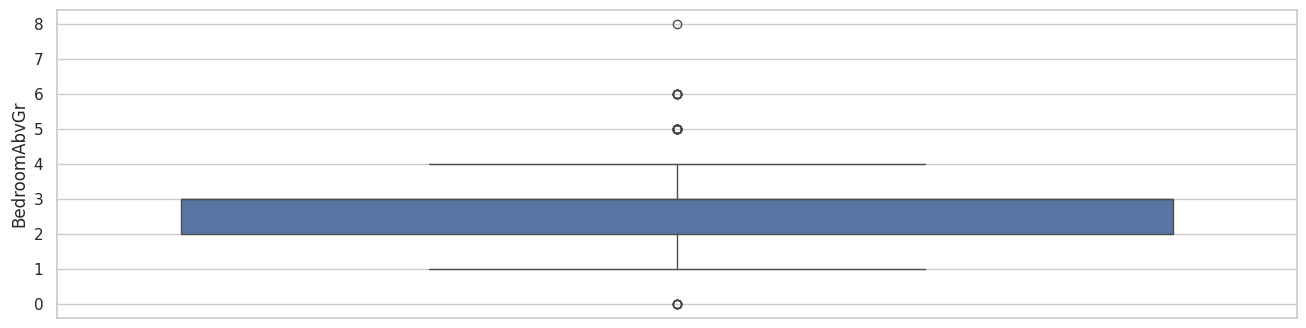

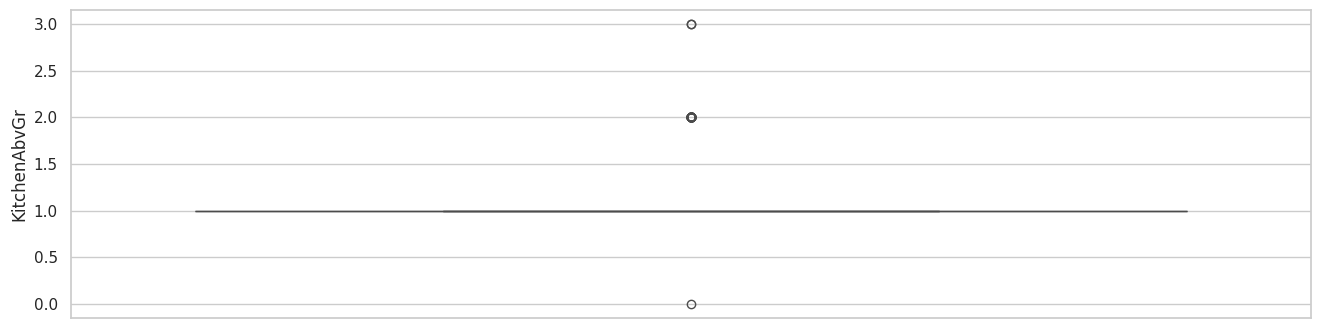

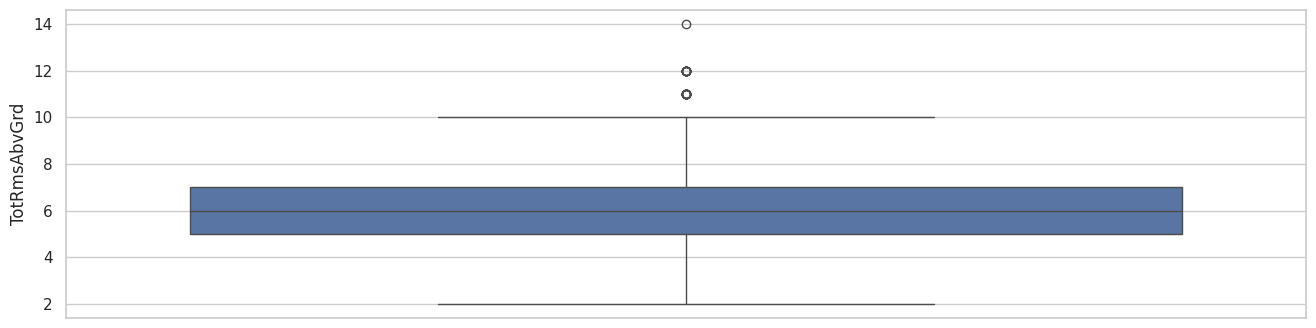

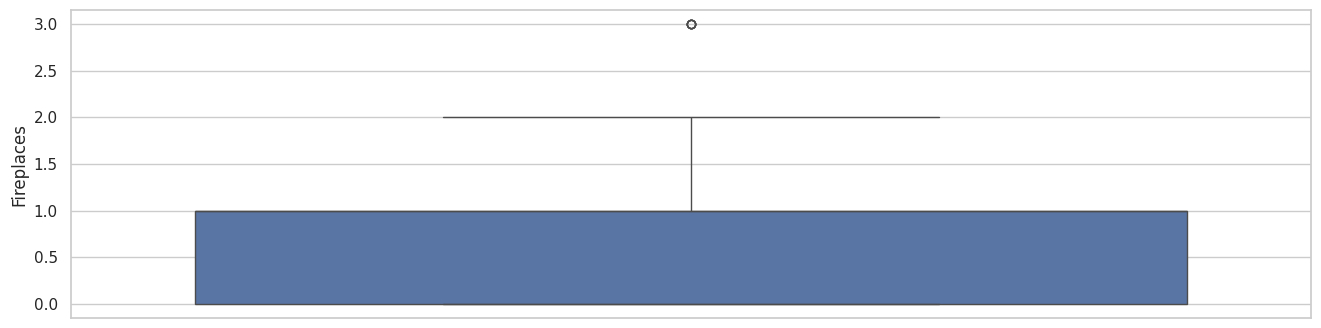

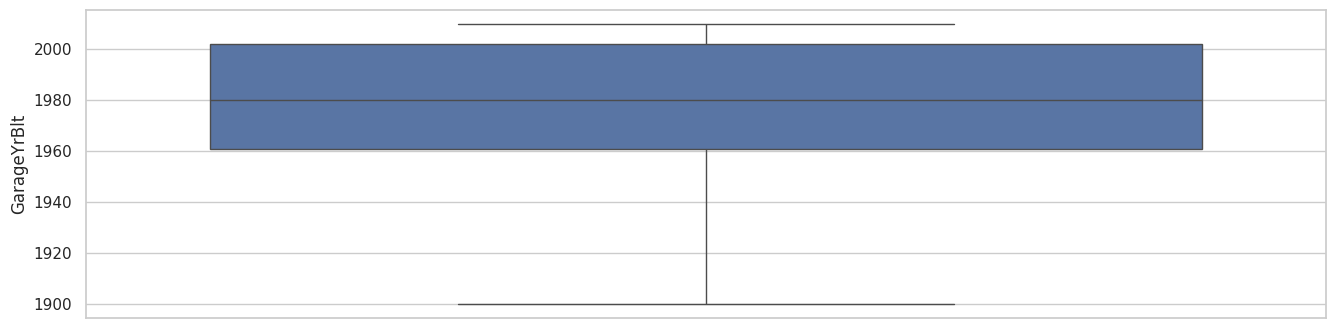

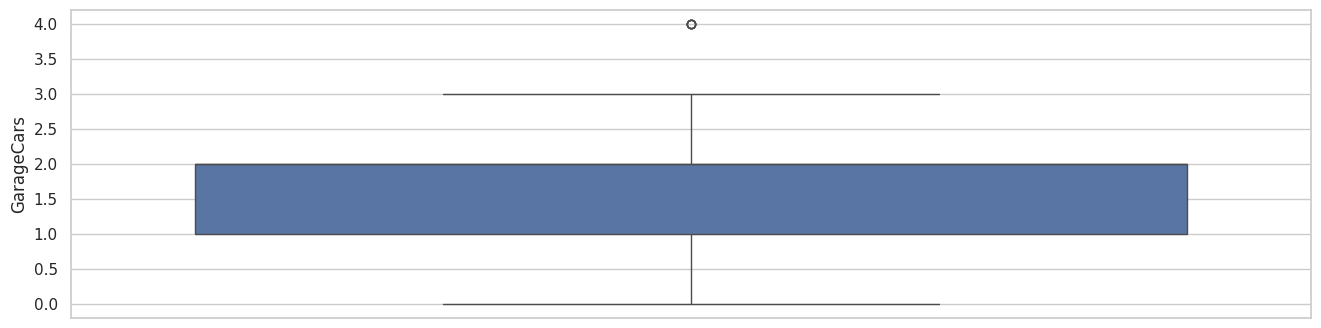

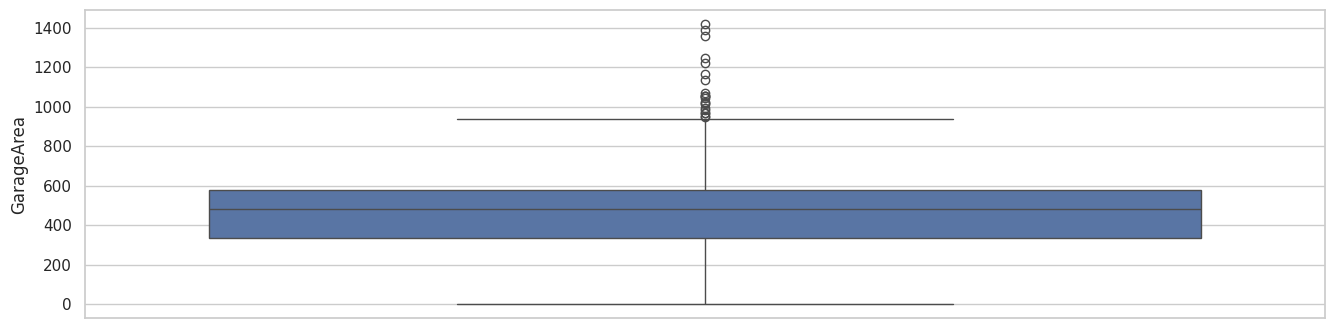

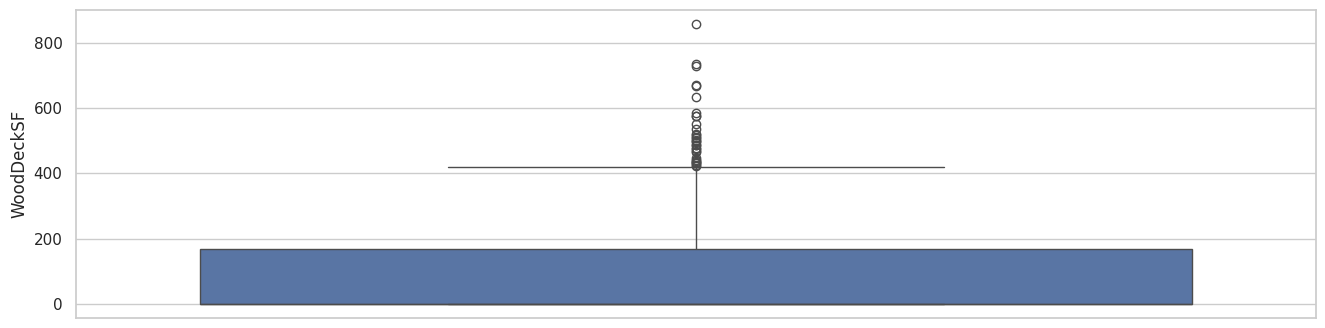

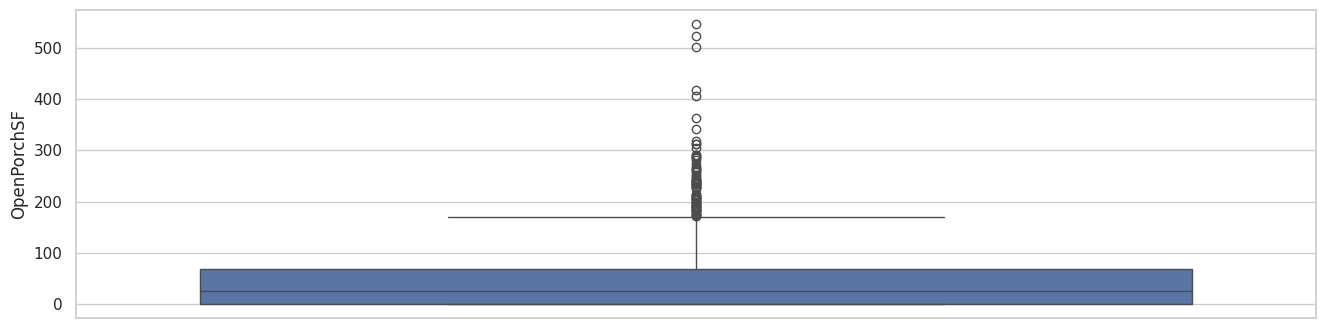

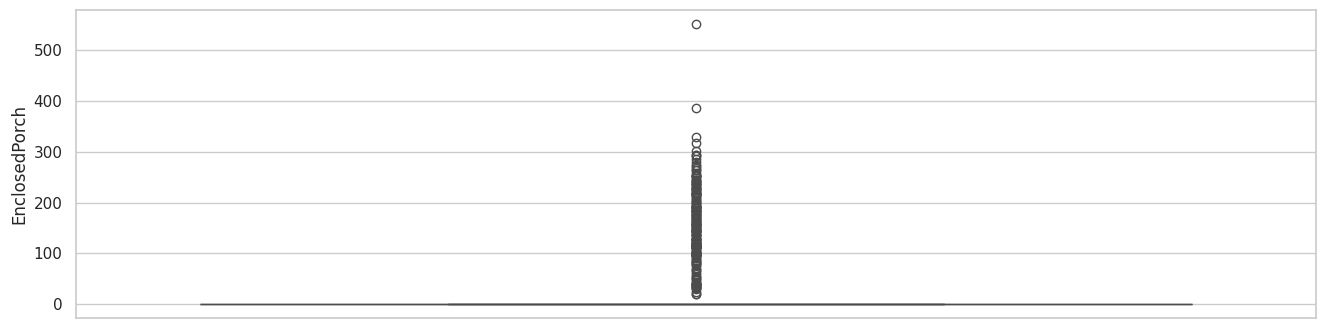

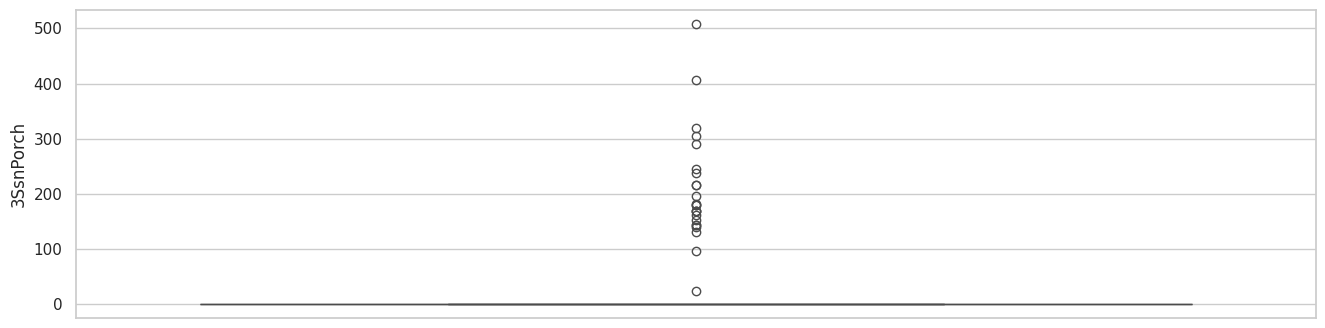

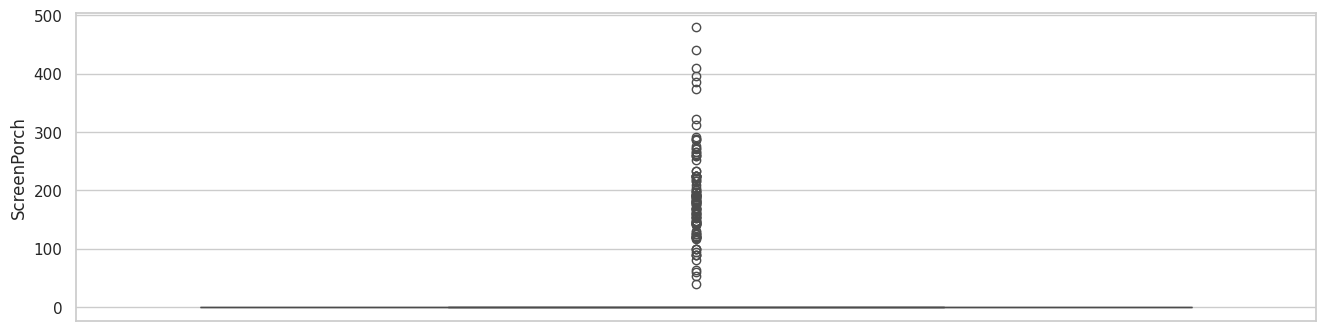

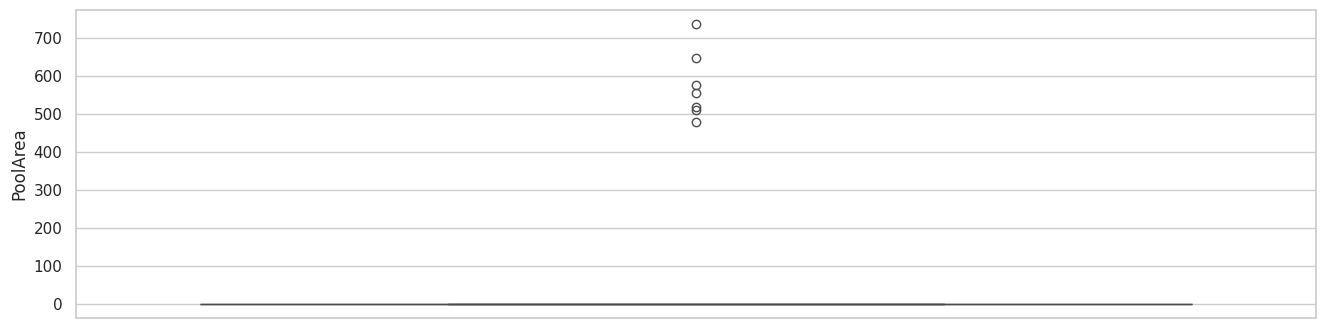

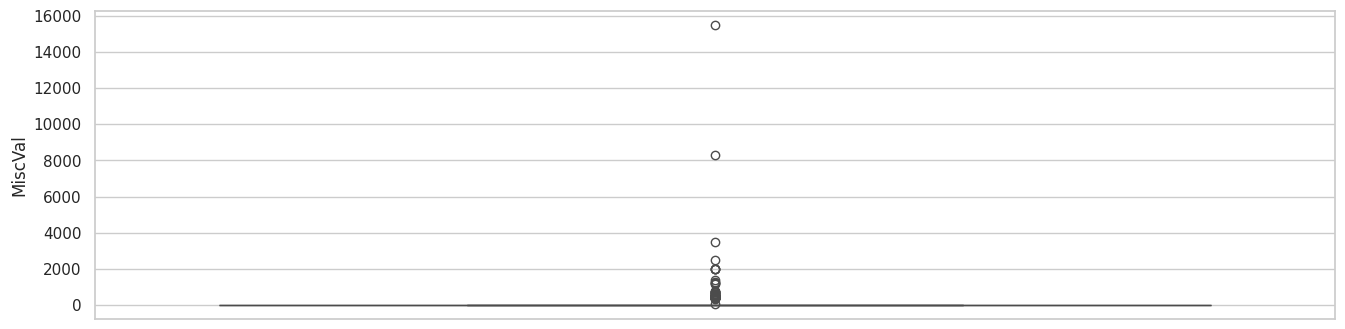

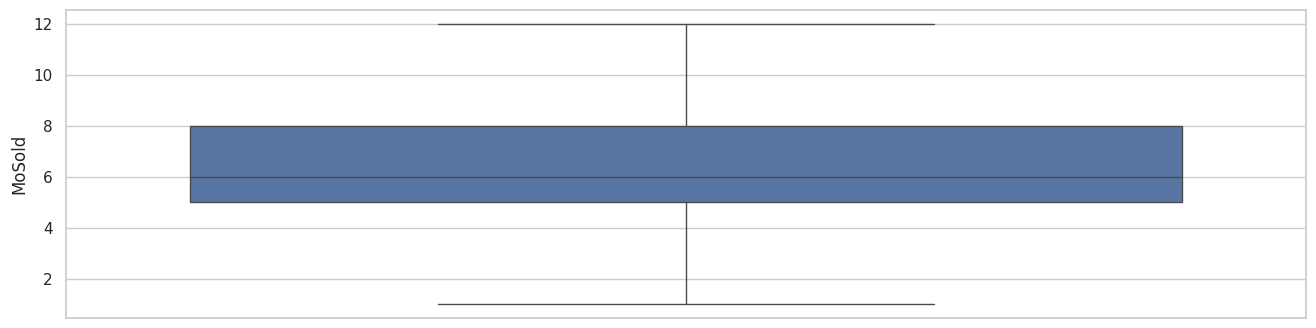

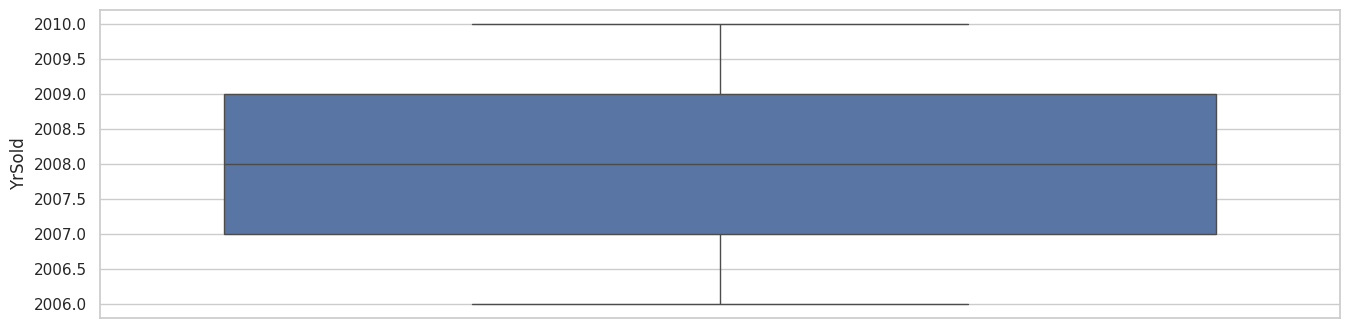

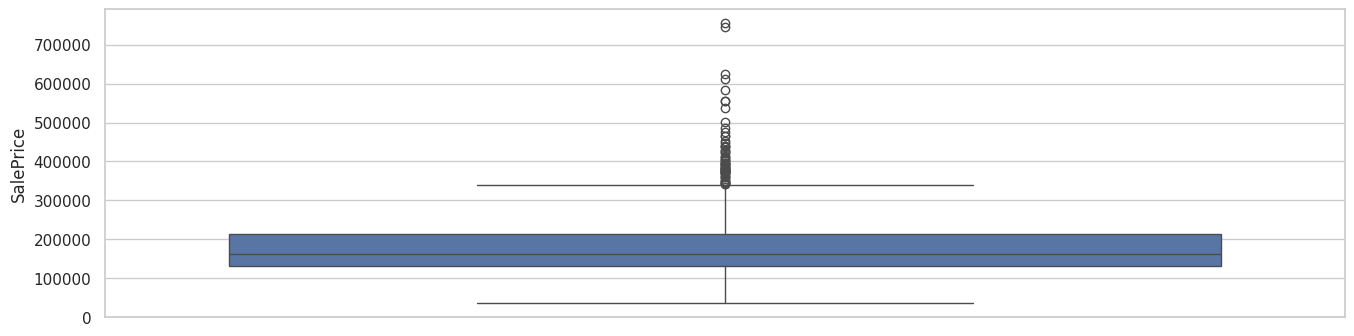

In [31]:
# find outliers for all the numerical dataset(before handling missing values)

numerical_df = df_train.select_dtypes(exclude=['object'])
numerical_df = numerical_df.drop(["Id"], axis=1)

for column in numerical_df:
    plt.figure(figsize=(16,4))
    sns.set_theme(style="whitegrid")
    sns.boxplot(numerical_df[column])

In [32]:
# correlation

corr = numerical_df.corr()

In [33]:
# this is the descriptive stats of the numerical data

numerical_df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [34]:
# and this is the descriptive stats of the target

# mean house price: 180,900
# standard deviation: 80,000
# min house price: 34,900
# max house price: 755,000

df_train.get("SalePrice").describe()

,SalePrice
count,1460.000000
mean,180921.195890
std,79442.502883
min,34900.000000
25%,129975.000000
50%,163000.000000
75%,214000.000000
max,755000.000000


<Axes: xlabel='SalePrice'>

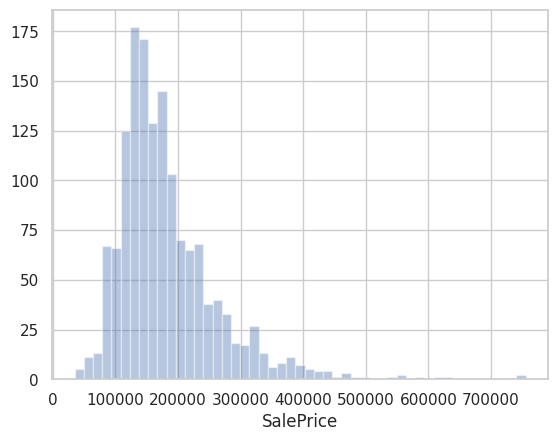

In [35]:
# the freq distribuition of the houses prices shows that most of them are between 100,000 and 200,000

sns.distplot(df_train.get("SalePrice"), kde=False)

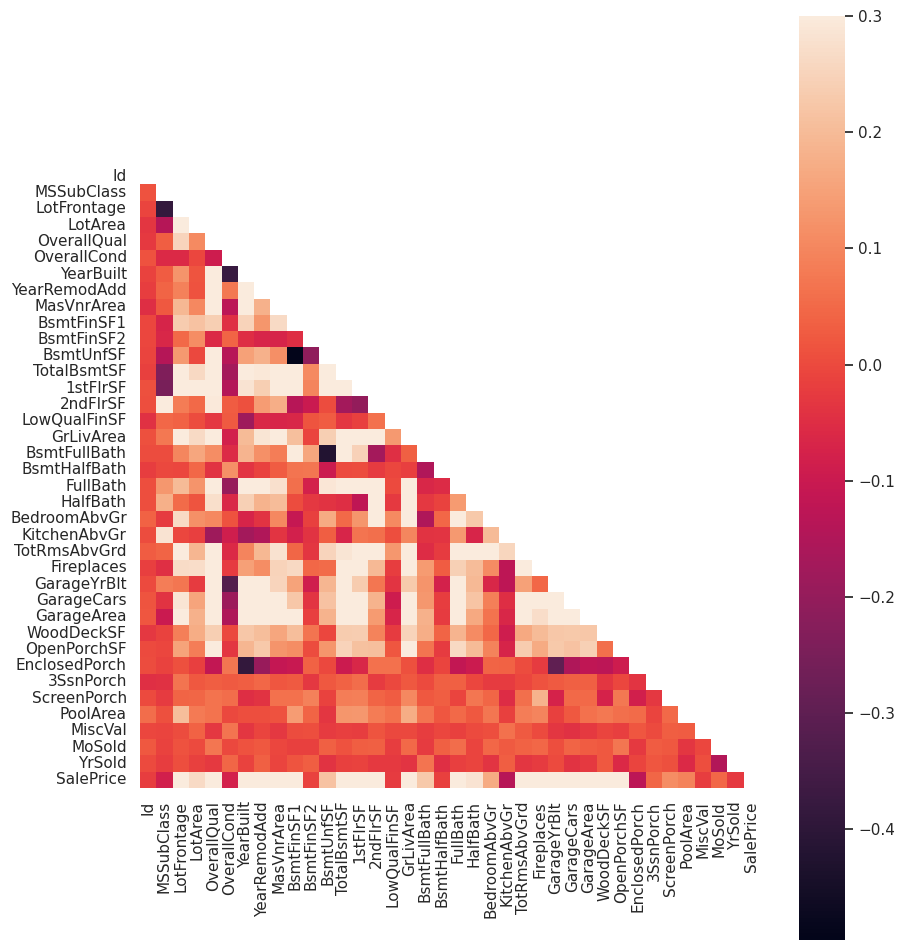

In [36]:
# correlation matrix between the variables
corr = df_train.corr(numeric_only=True) # Added numeric_only=True to handle non-numerical columns
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 12))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True)

In [37]:
# Calculate the correlation matrix considering only numerical columns
corr = df_train.corr(numeric_only=True)

# Sort the correlations with respect to 'SalePrice' in descending order
corr['SalePrice'].sort_values(ascending=False)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


In [38]:
# Biggest correlations:

# OverallQual      0.79 - Overall material and finish quality
# GrLivArea        0.71 - Above grade (ground) living area square feet
# GarageCars       0.64 - Size of garage in car capacity
# GarageArea       0.62 - Size of garage in square feet
# TotalBsmtSF      0.61 - Total square feet of basement area
# 1stFlrSF         0.60 - First Floor square feet
# FullBath         0.56 - Full bathrooms above grade
# TotRmsAbvGrd     0.53 - Total rooms above grade (does not include bathrooms)
# YearBuilt        0.52 - Original construction date
# YearRemodAdd     0.51 - Remodel date
# GarageYrBlt      0.48 - Year garage was built
# MasVnrArea       0.47 - Masonry veneer type
# Fireplaces       0.46 - Number of fireplaces

# lets analyse this correlations

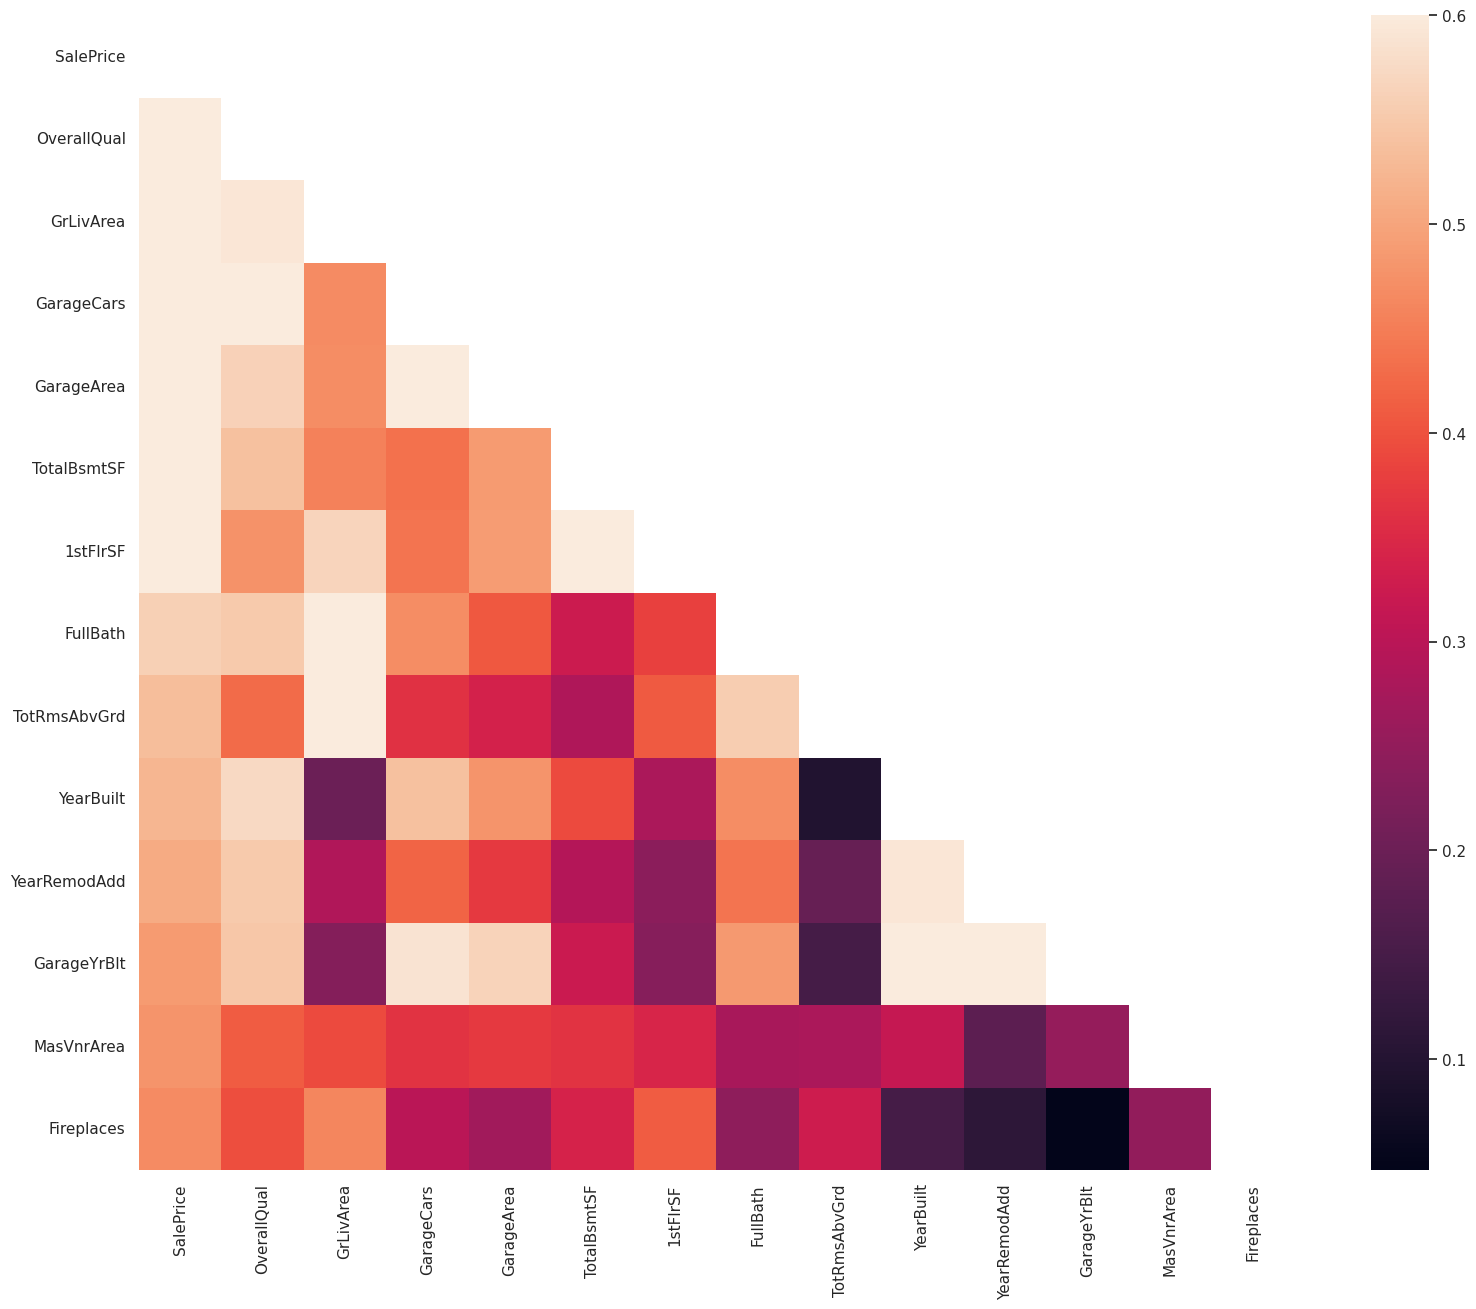

In [39]:
# this is a heatmap of the most correlated to the target features

# Changed 'data' to 'df_train' assuming this is the correct DataFrame
corr = df_train[['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
      'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt',
      'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'Fireplaces']].corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20, 15))
    ax = sns.heatmap(corr, mask=mask, vmax=.6, square=True)

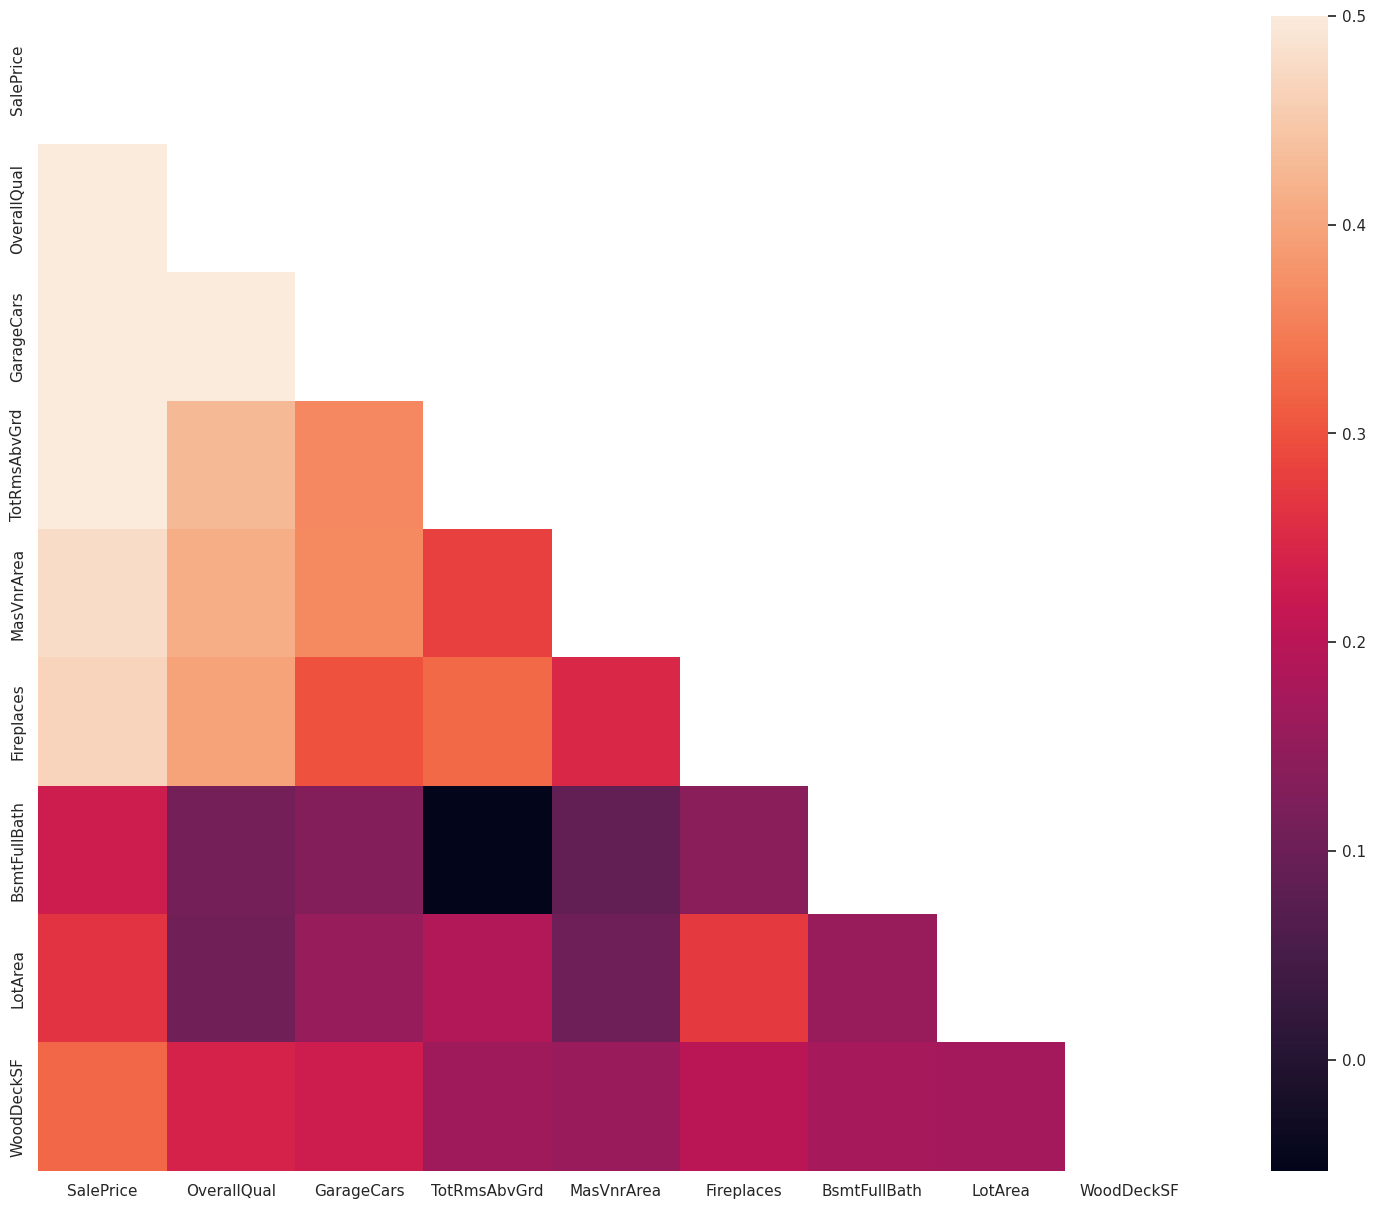

In [40]:
# lets get more features, that are less correlated but still are able to give information

corr = df_train[['SalePrice', 'OverallQual', 'GarageCars','TotRmsAbvGrd','MasVnrArea', 'Fireplaces', 'BsmtFullBath', 'LotArea' ,'WoodDeckSF']].corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20, 15))
    ax = sns.heatmap(corr, mask=mask, vmax=.5, square=True)

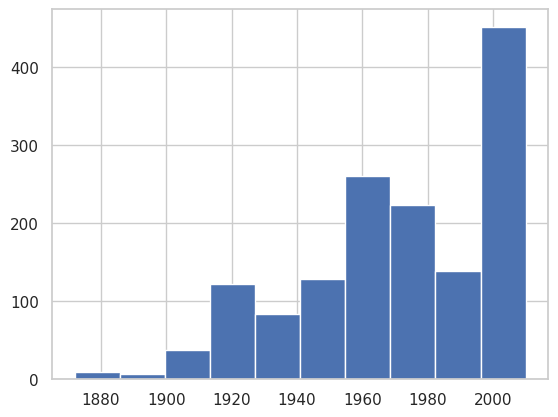

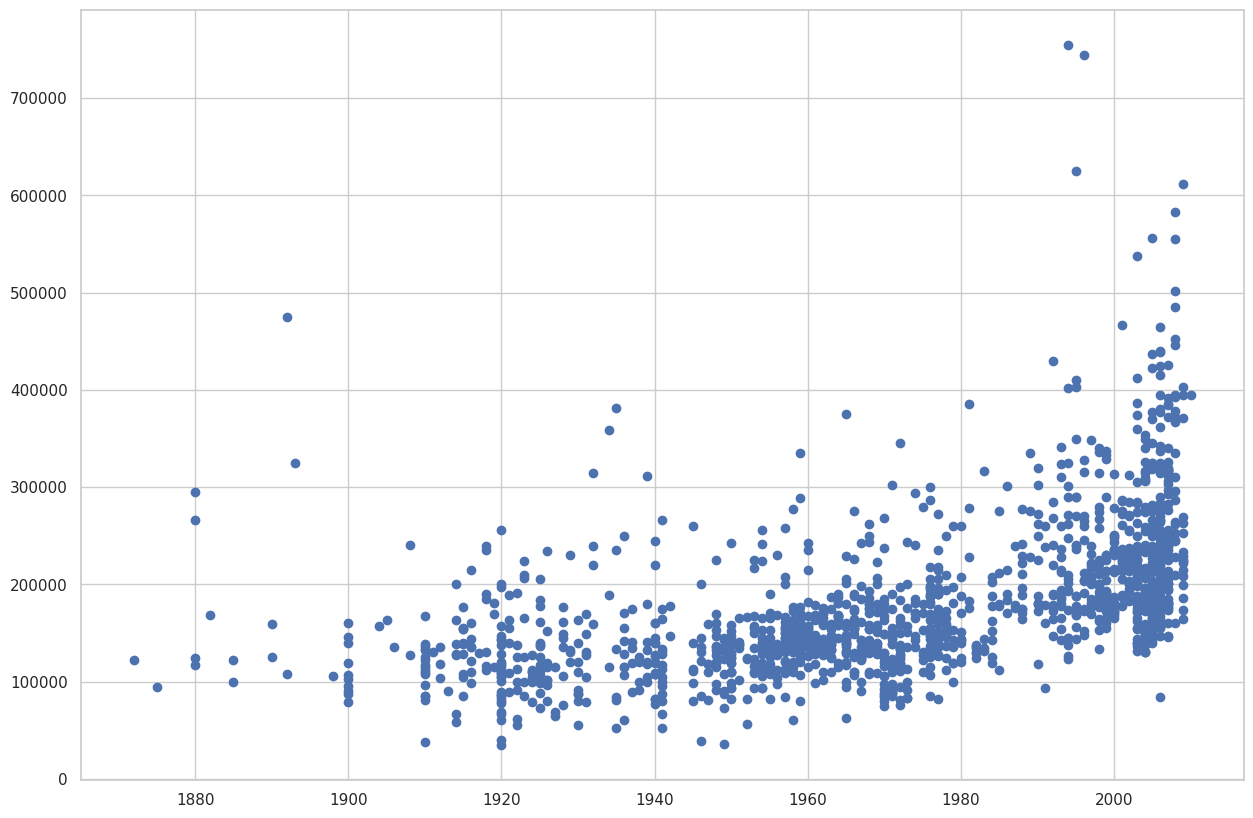

In [41]:
plt.hist(df_train['YearBuilt'])
plt.show()

# although we can see a pattern here, this feature is highly correlated to many others, making model have high multicolinirarity

plt.figure(figsize=(15, 10))

plt.scatter(df_train['YearBuilt'],df_train['SalePrice'])

plt.show()

In [42]:
# so this is the features that we pre-selected for the numerical part

corr

,SalePrice,OverallQual,GarageCars,TotRmsAbvGrd,MasVnrArea,Fireplaces,BsmtFullBath,LotArea,WoodDeckSF
SalePrice,1.000000,0.790982,0.640409,0.533723,0.477493,0.466929,0.227122,0.263843,0.324413
OverallQual,0.790982,1.000000,0.600671,0.427452,0.411876,0.396765,0.111098,0.105806,0.238923
GarageCars,0.640409,0.600671,1.000000,0.362289,0.364204,0.300789,0.131881,0.154871,0.226342
TotRmsAbvGrd,0.533723,0.427452,0.362289,1.000000,0.280682,0.326114,-0.053275,0.190015,0.165984
MasVnrArea,0.477493,0.411876,0.364204,0.280682,1.000000,0.249070,0.085310,0.104160,0.159718
Fireplaces,0.466929,0.396765,0.300789,0.326114,0.249070,1.000000,0.137928,0.271364,0.200019
BsmtFullBath,0.227122,0.111098,0.131881,-0.053275,0.085310,0.137928,1.000000,0.158155,0.175315
LotArea,0.263843,0.105806,0.154871,0.190015,0.104160,0.271364,0.158155,1.000000,0.171698
WoodDeckSF,0.324413,0.238923,0.226342,0.165984,0.159718,0.200019,0.175315,0.171698,1.000000


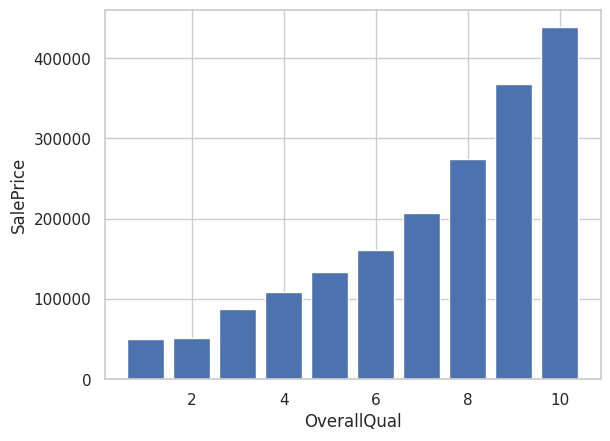

In [43]:
# now lets look on how they related to our target

# the OverallQual is the most correlated and its follows pretty mutch a good logic, higher the overall higher the price.

x1 = df_train.groupby('OverallQual').agg({'SalePrice':'mean'}).reset_index()

plt.bar(x1['OverallQual'], x1['SalePrice'])
plt.xlabel("OverallQual")
plt.ylabel("SalePrice")
plt.show()

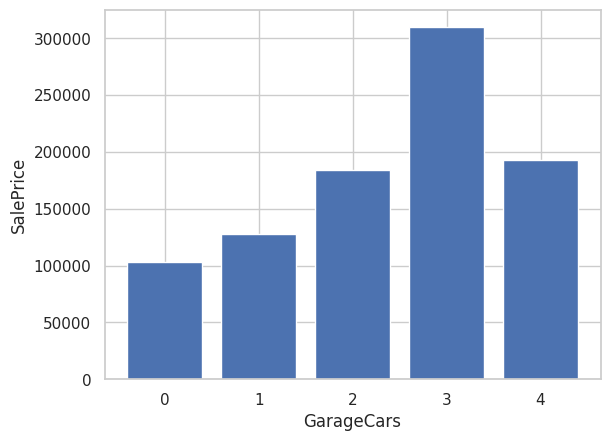

In [44]:
df_train['GarageCars'].value_counts()
x1 = df_train.groupby('GarageCars').agg({'SalePrice':'mean'}).reset_index()

plt.bar(x1['GarageCars'], x1['SalePrice'])
plt.xlabel("GarageCars")
plt.ylabel("SalePrice")
plt.show()

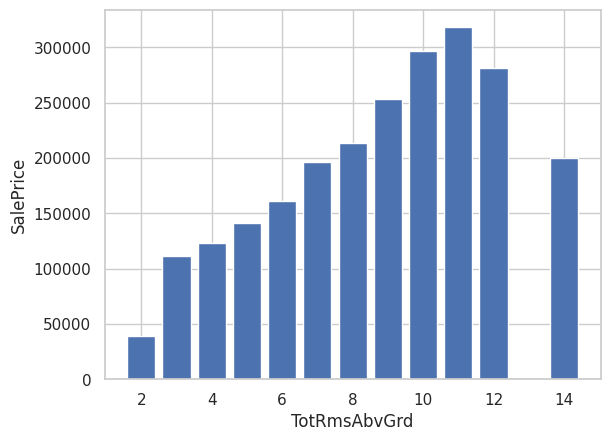

In [45]:
df_train['TotRmsAbvGrd'].value_counts()
x1 = df_train.groupby('TotRmsAbvGrd').agg({'SalePrice':'mean'}).reset_index()

plt.bar(x1['TotRmsAbvGrd'], x1['SalePrice'])
plt.xlabel("TotRmsAbvGrd")
plt.ylabel("SalePrice")
plt.show()

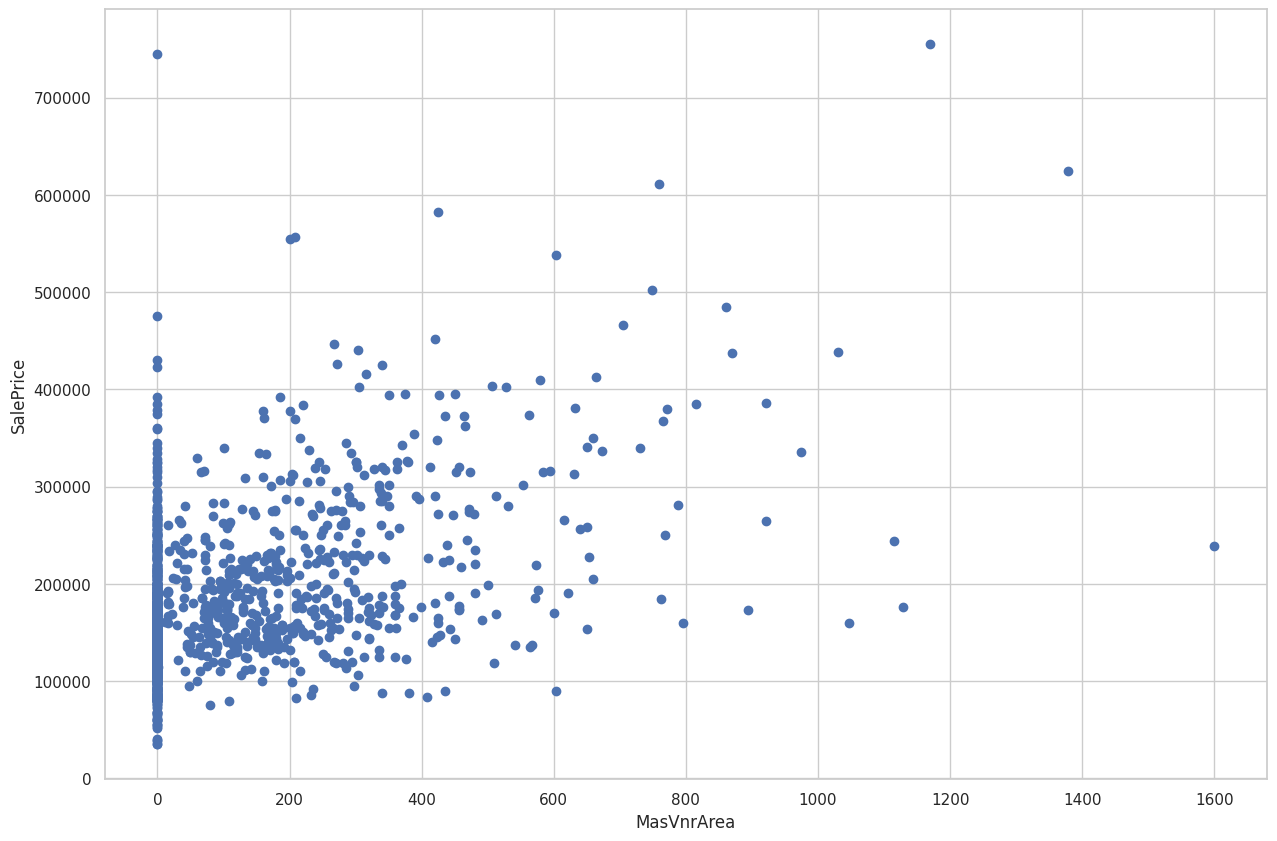

In [46]:
df_train['MasVnrArea'].value_counts()
plt.figure(figsize=(15, 10))

plt.scatter(df_train['MasVnrArea'], df_train['SalePrice'])
plt.xlabel("MasVnrArea")
plt.ylabel("SalePrice")
plt.show()

In [47]:
# and the new one after the feature engineering

df_train[['SalePrice', 'OverallQual', 'GarageCars','TotRmsAbvGrd',]].corr()

,SalePrice,OverallQual,GarageCars,TotRmsAbvGrd
SalePrice,1.000000,0.790982,0.640409,0.533723
OverallQual,0.790982,1.000000,0.600671,0.427452
GarageCars,0.640409,0.600671,1.000000,0.362289
TotRmsAbvGrd,0.533723,0.427452,0.362289,1.000000


In [48]:
df_test.isna().sum()

,0
Id,0
MSSubClass,0
MSZoning,4
LotFrontage,227
LotArea,0
...,...
MiscVal,0
MoSold,0
YrSold,0
SaleType,1


In [52]:
X = df.drop(['SalePrice'], axis=1)
y = df['SalePrice']

In [57]:
# Check the data types of all columns
print(df_train.dtypes)

# Identify columns with object (string) dtype
object_cols = df_train.select_dtypes(include=['object']).columns
print(object_cols)

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [58]:
# Drop the columns with string values
df_train = df_train.drop(columns=object_cols)

In [64]:
# Drop the columns with string values from X only if they exist
for col in object_cols:
    if col in X.columns:
        X = X.drop(columns=col)

# Impute missing values using SimpleImputer
!pip install scikit-learn
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean') # or strategy='median'
X = imputer.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
model = RandomForestRegressor(n_estimators=300, random_state=42)
model.fit(X_train, y_train)

#Make predictions
y_pred = model.predict(X_test)

In [69]:
# accuracy
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(y_test, y_pred)
mean_absolute_error = mean_absolute_error(y_test, y_pred)
r2_score = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mean_absolute_error)
print("R2 Score:", r2_score)

Mean Squared Error: 868336290.0674578
Mean Absolute Error: 18119.980844748858
R2 Score: 0.8867927821304623


In [68]:
# Predict the SalePrice for the test dataset
# Drop the columns with string values from df_test
for col in object_cols:
    if col in df_test.columns:
        df_test = df_test.drop(columns=col)

# Impute missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean') # or strategy='median'
df_test_imputed = imputer.fit_transform(df_test) # Impute missing values in df_test

y_pred_test = model.predict(df_test_imputed)

# Prepare the submission file
submission = pd.DataFrame({
    'Id': df_test.index,
    'SalePrice': y_pred_test
})

# Save the submission file
submission_file_path = '/content/sample_submission.csv'
submission.to_csv(submission_file_path, index=False)

print(f"Submission file saved to {submission_file_path}")

Submission file saved to /content/sample_submission.csv
